TIEMPO_MUERTO_EMPRESA
3644.0
None
NÚMERO DE VEHÍCULOS UTILIZADOS MODELO
10
Set parameter MIPGap to value 0.1
Set parameter OutputFlag to value 1
Set parameter MIPFocus to value 3
Set parameter Cuts to value 3
Set parameter TimeLimit to value 1380
Set parameter LogFile to value "gurobi.log"
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  1380
MIPGap  0.1
MIPFocus  3
Cuts  3

Optimize a model with 245 rows, 6948 columns and 20600 nonzeros
Model fingerprint: 0x697de46c
Variable types: 0 continuous, 6948 integer (6948 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 74 rows and 3146 columns
Presolve time: 0.16s
Presolved: 171 rows

c:\Users\melco\OneDrive\Escritorio\TRABAJO_1\mapas_puntos_de_apoyo\Researching_Model_Desing\notebooks\src\DataProcessing\read_data.py:329: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultado_df = pd.concat([resultado_df, nueva_fila], ignore_index=True)


TIEMPO MUERTO MODELO
ORD
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
118    7.0
119    1.0
120    2.0
121    3.0
122    4.0
Name: TIEMPO EN ANDÉN, Length: 122, dtype: float64
928.0
NÚMERO DE VEHÍCULOS UTILIZADOS MODELO
10


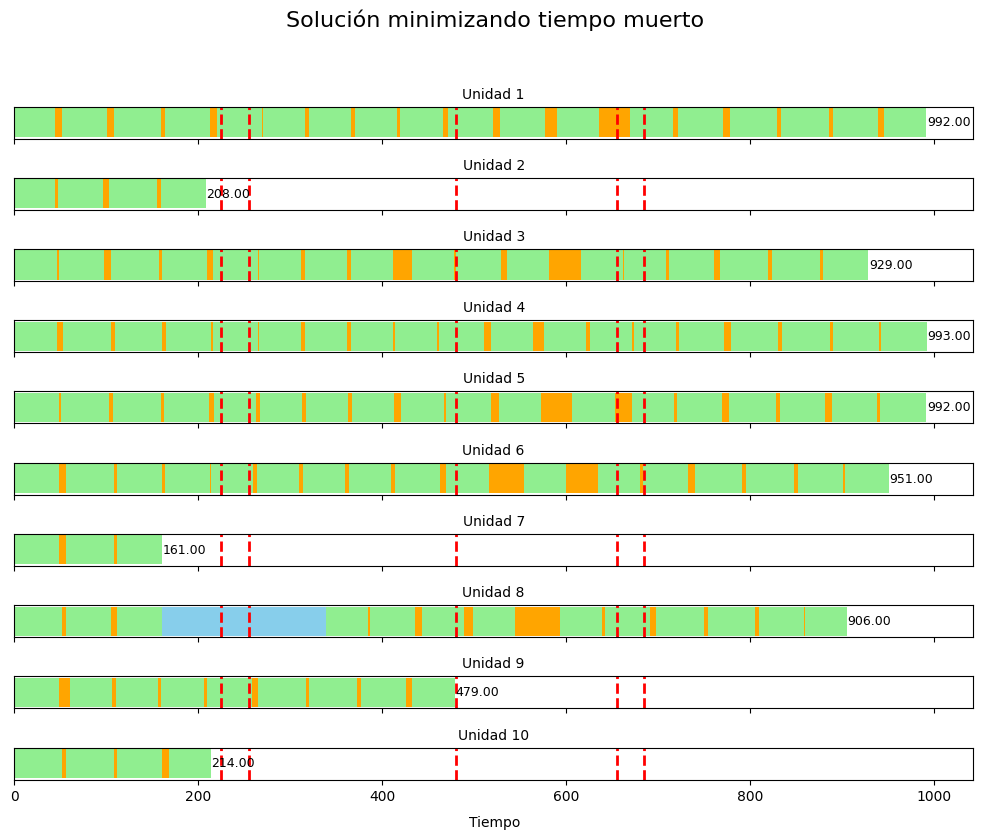

In [4]:
import src.DataProcessing.read_data as rd
import src.DataProcessing.transform_data as td
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.DataProcessing.read_data import lectura_alimentadora_norte
from src.DataProcessing.transform_data import hora_a_minutos
from src.DataProcessing.read_data import crear_dataframe_resultado
from src.DataProcessing.read_data import lectura_alimentadora_norte
from src.DataProcessing.read_data import crear_dataframe_resultado

ruta_excel = '../alimentadores_norte_1/Interterminal-Labrador-Carcelén.xlsx'
ruta="Ordinario"
df = lectura_alimentadora_norte(ruta_excel,ruta)
print("TIEMPO_MUERTO_EMPRESA")
print(print(df["TIEMPO EN ANDÉN"].apply(hora_a_minutos).sum(skipna=True)))

print("NÚMERO DE VEHÍCULOS UTILIZADOS MODELO")
print(max(df["COD. OP."]))
def obtener_diccionario_costo_completo(df, nodo_inicio=0, nodo_final=1000):
    """
    Devuelve un diccionario {(origen, destino): costo} incluyendo arcos de depósito.
    - nodo_inicio: número del depósito de salida (por defecto 0)
    - nodo_final: número del depósito de llegada (por defecto 500)
    """
    costos = {}
    for i, row_i in df.iterrows():
        for j, row_j in df.iterrows():
            if row_j['HORA_SALIDA'] > row_i['HORA_LLEGADA']:
                costo = row_j['HORA_SALIDA'] - row_i['HORA_LLEGADA']
                costos[(int(row_i['ORD']), int(row_j['ORD']))] = costo
        # Arco desde depósito de inicio
        costos[(nodo_inicio, int(row_i['ORD']))] = 0
        # Arco hacia depósito final (500)
        costos[(int(row_i['ORD']), nodo_final)] = 0
    return costos


costos = obtener_diccionario_costo_completo(df)

arcos=costos.keys()
N = df['ORD'].unique()

capacidad=max(df["COD. OP."])

import gurobipy as gp
from gurobipy import GRB


m1 = gp.Model('Asignacion-Flota-V1')
# Terminar al alcanzar un Gap del 20%
m1.Params.MIPGap = 0.10
m1.setParam('OutputFlag', 1)
# Enfocar estrategia en mejorar la cota dual
m1.Params.MIPFocus = 3

# Fijar generación muy agresiva de cortes
m1.Params.Cuts = 3

# Terminar luego de 180 segundos
m1.Params.TimeLimit = 1380

x = m1.addVars(arcos,vtype=GRB.BINARY,name='x')
# Update model to integrate new variables
m1.setParam('LogFile', 'gurobi.log')

m1.setObjective(gp.quicksum(costos[i,j]*x[i,j] for i,j in arcos),GRB.MINIMIZE)

m1.addConstrs((x.sum(n,'*') == 1 for n in N), name=f"Constraints")
m1.addConstrs((x.sum('*',i)-x.sum(i,'*')==0 for i in N ),name=f'conservacion')

m1.addConstr((x.sum(0,'*') <= capacidad), name=f"Constraints_2")
m1.write('Modelo.lp')

m1.optimize()

print("Número de variables:", m1.NumVars)
print("Número de restricciones:", m1.NumConstrs)


df=lectura_alimentadora_norte(ruta_excel,ruta)
base=crear_dataframe_resultado(m1,df)
#print(base)
import os
nombre_archivo = os.path.basename(ruta_excel)
circuito = os.path.splitext(nombre_archivo)[0]
ruta = f"C:\\Users\\melco\\OneDrive\\Escritorio\\TRABAJO_1\\mapas_puntos_de_apoyo\\Researching_Model_Desing\\data_modelo\\{circuito}_modelo_tiempo_muerto.xlsx"
 # Cambia esta ruta a donde quieras guardar

# Guardar como archivo Excel
base.to_excel(ruta, index=False)

print("TIEMPO MUERTO MODELO")
print(base["TIEMPO EN ANDÉN"])
print(sum(base["TIEMPO EN ANDÉN"]))

print("NÚMERO DE VEHÍCULOS UTILIZADOS MODELO")
print(max(base["COD. OP."]))

def visualizar(base):
    """
    Función para graficar los tiempos de andén y de viaje por unidad operativa.
    
    Parámetro:
    - base: DataFrame que debe contener las columnas:
      'TIEMPO EN ANDÉN', 'HORA_LLEGADA', 'HORA_SALIDA', 'COD. OP.'
    """
    base = base.copy()  # para no modificar el df original
    
    base['ANDEN_MINUTOS'] = base['TIEMPO EN ANDÉN']
    base['TIEMPO_VIAJE'] = base['HORA_LLEGADA'] - base['HORA_SALIDA']
    #print(base['ANDEN_MINUTOS'])

    # Umbral de color para el tiempo en andén
    valor_umbral = 100

    # Unidades únicas
    unidades = base['COD. OP.'].unique()

    # Crear subgráficos por unidad
    fig, axs = plt.subplots(len(unidades), 1, figsize=(10, len(unidades)*1/1.15), sharex=True)

    # Líneas verticales de referencia
    lineas_verticales = [225, 255, 480, 655, 685]

    resultados = []
    contadorAux = 1

    for i, unidad in enumerate(unidades):
        base_unidad = base[base['COD. OP.'] == unidad]
        
        Type = []
        Time = []
        Colors = []
        
        for _, row in base_unidad.iterrows():
            if not pd.isna(row['ANDEN_MINUTOS']):
                Type.append('A1')
                Time.append(row['ANDEN_MINUTOS'])
                Colors.append('orange' if row['ANDEN_MINUTOS'] <= valor_umbral else 'skyblue')
            Type.append('A2')
            Time.append(row['TIEMPO_VIAJE'])
            Colors.append('lightgreen')
        
        data = pd.DataFrame({
            "Type": Type,
            "Time": Time,
            "Colors": Colors
        })

        if contadorAux <= 15:
            resultados.append(data)
        
        contadorAux += 1
        left = 0
        bar_height = 0.3
        
        for _, row in data.iterrows():
            axs[i].barh(y=0, width=row['Time'], left=left, color=row['Colors'], height=bar_height)
            left += row['Time']
        
        total_time = left
        axs[i].text(left + 0.5, 0, f'{total_time:.2f}', va='center', fontsize=9)
        axs[i].set_yticks([])
        axs[i].set_title(f'Unidad {unidad}', fontsize=10)

        for x_value in lineas_verticales:
            axs[i].axvline(x=x_value, color='red', linestyle='--', linewidth=2)

    fig.text(0.5, 0.04, 'Tiempo', ha='center')
    fig.suptitle('Solución minimizando tiempo muerto', fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

visualizar(base)